In [ ]:
import numpy as np
import torch
import math
from torch import nn
import torch.nn.functional as F
from torch import distributions as pyd

from utils import util, buffer
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from sklearn.decomposition import NMF
from utils import util, buffer
import pickle
import h5py
from visualize import plot_gif

In [53]:
state_dim = 16
action_dim = 16
n_task = 10
replay_buffer = buffer.ReplayBuffer(state_dim, action_dim, 1000000, 'cpu')
replay_buffer_path = f'./kms/replay_buffer_mildnormalized200_discreteaction.pth'
replay_buffer.load_state_dict(torch.load(replay_buffer_path))
print(f'Replay buffer loaded from {replay_buffer_path}')
idx = np.where(replay_buffer.task == 2)[0][48]
print('idx:', idx)
action = replay_buffer.action
print(np.unique(action, return_counts=True))
task = replay_buffer.task
print(task[idx:idx+13])

Replay buffer loaded from ./kms/replay_buffer_mildnormalized200_discreteaction.pth
idx: 1434
(array([0., 1., 2., 3., 4.]), array([ 118466,  980433, 4744336, 1029533,  127200]))
[[2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]]


actionseq: [[2. 2. 2. 1. 2. 1. 1. 2. 1. 2. 2. 1. 1. 1. 2. 1.]
 [3. 2. 3. 1. 2. 2. 2. 1. 2. 1. 2. 1. 2. 2. 2. 1.]
 [3. 2. 2. 1. 2. 0. 2. 0. 1. 1. 1. 1. 1. 0. 1. 1.]
 [3. 1. 2. 2. 2. 2. 1. 2. 1. 1. 2. 1. 2. 2. 2. 1.]
 [3. 1. 2. 1. 1. 2. 2. 2. 2. 2. 1. 2. 1. 1. 1. 2.]
 [2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 1. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 1. 1. 1. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 3. 2. 3. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 3. 2. 2. 3. 2. 2. 2. 2.]
 [2. 3. 2. 3. 3. 2. 2. 3. 2. 2. 2. 2. 2. 3. 3. 3.]
 [2. 2. 2. 3. 2. 3. 3. 2. 2. 3. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 3. 2. 2. 2. 3. 1. 3. 3. 3. 1. 2.]]
./figure/kms/mildnormalized200_discreteaction.gif


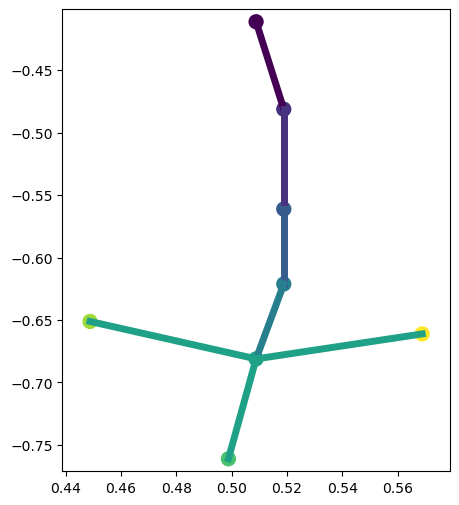

In [52]:
stateseq = replay_buffer.state[1434:1447]
actionseq = replay_buffer.action[1434:1447]
print('actionseq:', actionseq)
plot_gif(stateseq, f'./figure/kms/mildnormalized200_discreteaction.gif')

In [3]:
accept = torch.randn(1,1)<0.5
A = torch.randn(3,4)
B = torch.ones(3,4)
C = torch.where(accept, A, B)
print(C)

tensor([[ 0.2379, -0.0859, -2.0457,  1.4932],
        [-0.2551, -0.4723,  0.1096, -1.2483],
        [ 0.0663, -1.3599, -0.2168, -1.3491]])


In [4]:
a = torch.tensor([1.2, 2.5, 3.7])
torch.round(a).long()

tensor([1, 2, 4])

In [2]:
def check_multiple_step_rollout(lr, syllable, replay_buffer):
    syllable_idx = np.where(replay_buffer.task == syllable)[0]
    transition = np.where(np.diff(syllable_idx) != 1)[0]+1
    print(len(transition))
    state_seqs = [None] * (len(transition)-1)
    for i in range(len(transition)-1):
        # print(transition[i], transition[i+1])
        # print(syllable_idx[transition[i]:transition[i+1]-1])
        state_seqs[i] = replay_buffer.state[syllable_idx[transition[i]:transition[i+1]-1]]
        assert state_seqs[i].shape[-1] == 16
    all_error = np.zeros(len(transition)-1)
    for i in range(len(state_seqs)):
        imitation_state_seq = np.zeros_like(state_seqs[i])
        # print(state_seqs[i], transition[i], syllable_idx[transition[i]:transition[i+1]-1])
        imitation_state_seq[0] = state_seqs[i][0]
        for j in range(1, state_seqs[i].shape[0]):
            imitation_state_seq[j] = lr.predict(imitation_state_seq[j-1].reshape(1, -1)).reshape(-1)
        error = np.mean(np.abs(imitation_state_seq - state_seqs[i]))
        # print(i, error)
        all_error[i] = error
    # print('all:', all_error.mean())
    return all_error.mean()

In [ ]:
from sklearn.linear_model import LinearRegression
from visualize import plot_gif
lr = LinearRegression()
replay_buffer_path = './kms/train_data.pth'
replay_buffer_state_dict = torch.load(replay_buffer_path)
state_dim, action_dim = 16, 16
replay_buffer = buffer.ReplayBuffer(state_dim, action_dim, max_size=10000)
replay_buffer.load_state_dict(replay_buffer_state_dict)
state = replay_buffer_state_dict['state']
action = replay_buffer_state_dict['action']
print(state.shape, action.shape)    
action_onehot = torch.eye(action_dim)[action.long()]
next_state = replay_buffer_state_dict['next_state']
print(state.shape, next_state.shape)
# sa_input = np.concatenate([state, action], axis=1)
# split train and test buffer
# train_buffer_size = int(0.8 * len(znormalized_state))
# print(train_buffer_size)
lr.fit(state, action_onehot)
test_buffer_path = './kms/test_data.pth'
test_buffer_state_dict = torch.load(test_buffer_path)
test_state = test_buffer_state_dict['state']
test_action = test_buffer_state_dict['action']
test_action_onehot = torch.eye(action_dim)[test_action.long()]
test_next_state = test_buffer_state_dict['next_state']
test_action_pred = lr.predict(test_state)
error = np.abs(test_action_pred - test_action)
print(error.shape)
error_mean = np.mean(error, axis=0)
print(error_mean, error_mean.mean())
torch.save(lr, './kms/linear_model_discrete.pth')


(349998, 16) (349998, 16)
(87500, 16)
[0.3644246  0.36313503 0.37074135 0.36491215 0.38038559 0.37109492
 0.40129115 0.3936511  0.4571258  0.45046861 0.56214556 0.56401328
 0.46329955 0.45762357 0.46072547 0.4529573 ] 0.4298746899117995


(127103, 16) (127103, 80)
action: [[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]]
action: [[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]]
action: [[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]]
action: [[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]]
action: [[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]]
action: [[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]]
action: [[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]]
action: [[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]]
action: [[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]]
action: [[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]]
action: [[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]]
action: [[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]]
action: [[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]]
action: [[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]]
action: [[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]]
action: [[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]]
action: [[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]]
action: [[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]]
action: [[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]]
action: [[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]]
action: [[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]]
action: [[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]]
action

KeyboardInterrupt: 

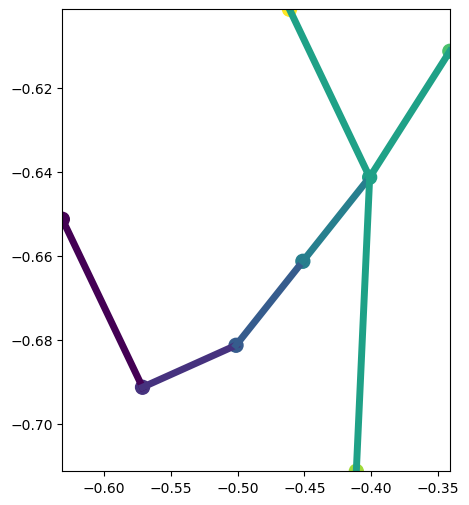

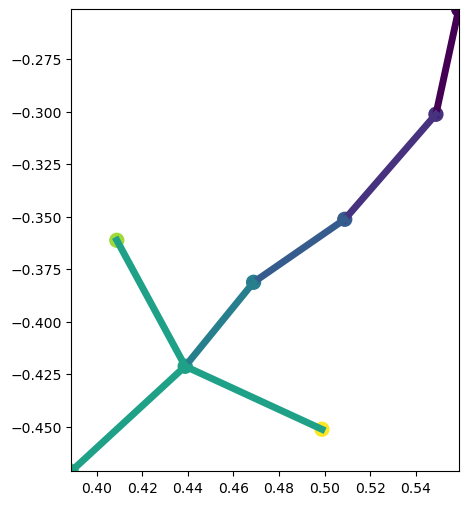

In [7]:
from sklearn.linear_model import LinearRegression
from visualize import plot_gif

replay_buffer_path = './kms/replay_buffer_mildnormalized200_discreteaction.pth'
replay_buffer_state_dict = torch.load(replay_buffer_path)
state_dim, action_dim = 16, 80
replay_buffer = buffer.ReplayBuffer(state_dim, action_dim, max_size=10000)
replay_buffer.load_state_dict(replay_buffer_state_dict)
timestep = 30
n_action = 5
n_action_dim = 16
state_seqs = np.zeros((timestep, state_dim))
# all_error = np.zeros((10,))
for syllable in range(10):
    lr = LinearRegression()
    all_idx = np.where(replay_buffer.task == syllable)[0]
    state = replay_buffer.state[all_idx]
    action = replay_buffer.action[all_idx]
    action_onehot = np.eye(n_action)[np.int64(action)].reshape(-1, n_action_dim*n_action)
    next_state = replay_buffer.next_state[all_idx]
    print(state.shape, action_onehot.shape)
    lr.fit(state, action_onehot)
    new_action_onehot_pred = lr.predict(state)

    # error = np.abs(new_next_state_pred - next_state)
    # print(error.shape)
    # error_mean = np.mean(error, axis=0)
    # print(error_mean, error_mean.mean())
    # all_error[syllable] = check_multiple_step_rollout(lr, syllable, replay_buffer)
    # print(syllable, all_error[syllable])
    sample_idx = all_idx[np.random.randint(len(all_idx))]
    state = replay_buffer.state[sample_idx]
    state_seqs[0] = state
    for i in range(1, timestep):
        action_onehot = lr.predict(state.reshape(1, -1))
        action = np.argmax(action_onehot.reshape(1, n_action_dim, n_action), axis=-1)
        print('action:', action)
        # print('action:', action.shape)
        next_state = (action-2)/100 + state
        state_seqs[i] = next_state
        state = next_state
    plot_gif(state_seqs, f'./figure/kms/linear_state_discrete/{syllable}task.gif')
    print(state_seqs[0].shape)
    # np.save(f'./kms/s_mean.npy', state_seqs[0].reshape(-1,2))
# print('all:', all_error.mean())

Load replay buffer

In [15]:
state_dim = 16
action_dim = 16
n_task = 10
replay_buffer_path = './kms/replay_buffer_continuous_allaction.pth'
replay_buffer = buffer.ReplayBuffer(state_dim, action_dim, 10000)
replay_buffer.load_state_dict(torch.load(replay_buffer_path))

In [17]:
scale_factor = 200
action_all = replay_buffer.action
print(action_all.shape[0])
# syllable_indicator = (replay_buffer.task == 3).squeeze()
# print(len(np.where(all_idx)[0]))
filtered_replay_buffer = buffer.ReplayBuffer(state_dim, action_dim, 10000)
size = replay_buffer.size
# filtered_replay_buffer.state = replay_buffer.state
# filtered_replay_buffer.next_state = replay_buffer.next_state
assert np.isclose(replay_buffer.state + replay_buffer.action, replay_buffer.next_state).all()
new_state = replay_buffer.state
new_next_state = replay_buffer.next_state

state_mean = np.mean(np.concatenate([new_state, new_next_state[-2:]], axis=0))
print(state_mean)
mildnormalized_state = (new_state - state_mean) / scale_factor
filtered_replay_buffer.state = mildnormalized_state

mildnormalized_next_state = (new_next_state - state_mean) / scale_factor + np.random.normal(0, 1/scale_factor, new_next_state.shape)
filtered_replay_buffer.next_state = mildnormalized_next_state

new_action = replay_buffer.action
# filtered_replay_buffer.action = new_action/2+2
mildnormalized_action = new_action / scale_factor
filtered_replay_buffer.action = mildnormalized_action

filtered_replay_buffer.reward = replay_buffer.reward
filtered_replay_buffer.done = replay_buffer.done
filtered_replay_buffer.task = replay_buffer.task
filtered_replay_buffer.next_task = replay_buffer.next_task
filtered_replay_buffer.size = replay_buffer.size
filtered_replay_buffer.ptr = 0

# assert np.isclose(filtered_replay_buffer.state + filtered_replay_buffer.action, filtered_replay_buffer.next_state).all()
torch.save(filtered_replay_buffer.state_dict(), './kms/replay_buffer_mildnormalized200_continuous_allaction.pth')

486124
305.6994938040755


In [18]:
state_dim = 16
action_dim = 16
n_task = 10
replay_buffer = buffer.ReplayBuffer(state_dim, action_dim, 10000)
replay_buffer.load_state_dict(torch.load('./kms/replay_buffer_mildnormalized200_continuous_allaction.pth'))
print(np.unique(replay_buffer.action))
# action_onehot = np.eye(5)[replay_buffer.action.astype(int)]
# print(action_onehot.shape)
# replay_buffer.action = action_onehot.reshape(action_onehot.shape[0], -1)
# replay_buffer.action = replay_buffer.action.astype(int)

[-1.01 -0.99 -0.98 -0.97 -0.96 -0.93 -0.9  -0.85 -0.84 -0.83 -0.8  -0.78
 -0.75 -0.7  -0.66 -0.63 -0.62 -0.6  -0.59 -0.58 -0.57 -0.56 -0.55 -0.54
 -0.53 -0.52 -0.5  -0.49 -0.48 -0.46 -0.45 -0.44 -0.43 -0.42 -0.4  -0.38
 -0.37 -0.36 -0.35 -0.34 -0.33 -0.32 -0.31 -0.3  -0.29 -0.28 -0.27 -0.26
 -0.25 -0.24 -0.23 -0.22 -0.21 -0.2  -0.19 -0.18 -0.17 -0.16 -0.15 -0.14
 -0.13 -0.12 -0.11 -0.1  -0.09 -0.08 -0.07 -0.06 -0.05 -0.04 -0.03 -0.02
 -0.01  0.    0.01  0.02  0.03  0.04  0.05  0.06  0.07  0.08  0.09  0.1
  0.11  0.12  0.13  0.14  0.15  0.16  0.17  0.18  0.19  0.2   0.21  0.22
  0.23  0.24  0.25  0.26  0.27  0.28  0.29  0.3   0.31  0.32  0.33  0.34
  0.35  0.36  0.37  0.38  0.39  0.4   0.41  0.43  0.44  0.48  0.49  0.51
  0.52  0.53  0.54  0.55  0.56  0.59  0.6   0.62  0.63  0.65  0.67  0.68
  0.72  0.78  0.8   0.82  0.83  0.84  0.85  0.86  0.92  0.93  0.99  1.01
  1.02]


In [10]:
idx = np.arange(replay_buffer.size)
np.random.shuffle(idx)
train_idx = idx[:int(replay_buffer.size * 0.8)]
test_idx = idx[int(replay_buffer.size * 0.8):]
train_data = {}
test_data = {}
key = ['state', 'action', 'next_state', 'reward', 'done', 'task', 'next_task']
for k in key:
    train_data[k] = replay_buffer.__getattribute__(k)[train_idx]
    test_data[k] = replay_buffer.__getattribute__(k)[test_idx]
train_data['size'] = len(train_idx)
test_data['size'] = len(test_idx)
train_data['ptr'] = 0
test_data['ptr'] = 0
# np.savez('./kms/train_data_sequential_discrete_action04.npz', **train_data)
# np.savez('./kms/test_data_sequential_discrete_action04.npz', **test_data)
torch.save(train_data, './kms/train_data.pth')
torch.save(test_data, './kms/test_data.pth')
print(len(train_idx), len(test_idx))
print(np.unique(train_data['action'], return_counts=True))
print(np.unique(test_data['action'], return_counts=True))
print(np.unique(train_data['done'], return_counts=True))
print(np.unique(test_data['done'], return_counts=True))

349998 87500
(array([0., 1., 2., 3., 4.]), array([  94918,  783917, 3794072,  825154,  101907]))
(array([0., 1., 2., 3., 4.]), array([ 23548, 196516, 950264, 204379,  25293]))
(array([0., 1.]), array([331161,  18837]))
(array([0., 1.]), array([82793,  4707]))


In [5]:
3795722/(94596+784483+3795722+823329+101838)

0.6778113732078469

In [8]:
dlc_sample = pickle.load(open('./kms/dlc_sample.pkl', 'rb'))
print(dlc_sample.keys())
print(dlc_sample['coordinates'].keys())
print(dlc_sample['coordinates']['22_04_26_cage4_0.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000'].shape)

dict_keys(['coordinates', 'bodyparts'])
dict_keys(['22_04_26_cage4_0.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000', '21_12_2_def6b_2.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000', '21_12_10_def6a_3.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000', '21_12_10_def6a_1_1.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000', '22_04_26_cage4_1_1.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000', '21_12_2_def6a_1.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000', '21_12_10_def6b_3.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000', '22_04_26_cage4_0_2.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000', '21_11_8_one_mouse.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000', '22_27_04_cage4_mouse2_0.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000'])
(53623, 9, 2)


In [9]:
results = h5py.File('./kms/results.h5', 'r')
print(np.array(results['22_04_26_cage4_0.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000']['syllable']))

[14 14 14 ...  3  3  3]


In [10]:
syllables = {k:v['syllable'] for k,v in results.items()}
print(syllables)

{'21_11_8_one_mouse.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000': <HDF5 dataset "syllable": shape (71524,), type "<i8">, '21_12_10_def6a_1_1.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000': <HDF5 dataset "syllable": shape (53512,), type "<i8">, '21_12_10_def6a_3.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000': <HDF5 dataset "syllable": shape (35818,), type "<i8">, '21_12_10_def6b_3.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000': <HDF5 dataset "syllable": shape (53527,), type "<i8">, '21_12_2_def6a_1.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000': <HDF5 dataset "syllable": shape (107507,), type "<i8">, '21_12_2_def6b_2.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000': <HDF5 dataset "syllable": shape (107520,), type "<i8">, '22_04_26_cage4_0.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000': <HDF5 dataset "syllable": shape (53623,), type "<i8">, '22_04_26_cage4_0_2.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000': <HDF5 dataset "syllable":

This proves that the states are sorted by instance frequency

In [11]:
# stateseqs = {
#         'name1': np.array([1, 1, 2, 2, 2, 3]),
#         'name2': np.array([0, 0, 0, 1])}
stateseq_flat = np.hstack(list(syllables.values()))
state_onsets = np.pad(np.diff(stateseq_flat).nonzero()[0] + 1, (1, 0))
stateseq_flat = stateseq_flat[state_onsets]
counts = np.bincount(stateseq_flat, minlength=77)
print(counts[:25])
print(np.all(np.diff(counts)<=0))


[6135 3715 3226 3165 2824 2584 2295 2043 1845  853  681  500  458  420
  329  328  294  212  204  181  134  122  117   82   72]
True


In [12]:
def rotate(state, action, next_state, reward, done, task, next_task):
    theta = np.random.uniform(0, 2*np.pi)
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    assert state.shape == (16, )
    assert action.shape == (16, )
    assert next_state.shape == (16, )
    assert np.isclose(state + action, next_state).all()
    new_state = (state.reshape(-1,2) @ rotation_matrix).reshape(-1)
    new_next_state = (next_state.reshape(-1,2) @ rotation_matrix).reshape(-1)
    new_action = (action.reshape(-1,2) @ rotation_matrix).reshape(-1)
    assert np.isclose(new_state + new_action, new_next_state).all()
    return new_state, new_action, new_next_state, reward, done, task, next_task
def shift(state, action, next_state, reward, done, task, next_task):
    shift = np.random.randn(2)
    # print('shift:', shift)
    assert state.shape == (16, )
    assert action.shape == (16, )
    assert next_state.shape == (16, )
    assert np.isclose(state + action, next_state).all()
    new_state = (state.reshape(-1,2) + shift).reshape(-1)
    new_next_state = (next_state.reshape(-1,2) + shift).reshape(-1)
    new_action = action
    # print('state:', state, new_state)
    # print('action:', action, new_action)
    # print('next_state:', next_state, new_next_state)
    # print('compare:', new_state + new_action, new_next_state)
    assert np.isclose(new_state + new_action, new_next_state).all()
    return new_state, new_action, new_next_state, reward, done, task, next_task
    

In [13]:
bodyparts=[
    'tail', 'spine4', 'spine3', 'spine2', 'spine1',
    'head', 'nose', 'right ear', 'left ear']
use_bodyparts=[
        'spine4', 'spine3', 'spine2', 'spine1',
        'head', 'nose', 'right ear', 'left ear']
use_bodyparts_idx = [bodyparts.index(bp) for bp in use_bodyparts]
state_dim = len(use_bodyparts) * 2
action_dim = len(use_bodyparts) * 2
n_task = 10 # filter out some non-frsequent tasks
extra_augmentation_step = 1
original_replay_buffer = buffer.ReplayBuffer(state_dim, action_dim, 1000000, 'cpu')
for name in dlc_sample['coordinates'].keys():
    print(name)
    for i in range(len(dlc_sample['coordinates'][name])-1):
        state = np.array(dlc_sample['coordinates'][name][i][use_bodyparts_idx].flatten())
        next_state = np.array(dlc_sample['coordinates'][name][i+1][use_bodyparts_idx].flatten())
        action = next_state - state
        task = np.array(results[name]['syllable'][i])
        next_task = np.array(results[name]['syllable'][i+1])
        done = np.where(next_task != task, 1, 0)
        assert not np.all(np.isnan(state))
        if task < n_task and next_task < n_task:
            original_replay_buffer.add(state, action, next_state, 0, done, task, next_task)
            # for j in range(extra_augmentation_step):
            #     an_item = shift(*rotate(state, action, next_state, 0, 0, task, next_task))
            #     assert np.isclose(an_item[0] + an_item[1], an_item[2]).all()
            #     original_replay_buffer.add(*an_item)
print(original_replay_buffer.size)



22_04_26_cage4_0.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000
21_12_2_def6b_2.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000
21_12_10_def6a_3.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000
21_12_10_def6a_1_1.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000
22_04_26_cage4_1_1.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000
21_12_2_def6a_1.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000
21_12_10_def6b_3.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000
22_04_26_cage4_0_2.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000
21_11_8_one_mouse.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000
22_27_04_cage4_mouse2_0.top.irDLC_resnet50_moseq_exampleAug21shuffle1_500000
486124


In [14]:
print(np.unique(original_replay_buffer.action, return_counts=True))
torch.save(original_replay_buffer.state_dict(), './kms/replay_buffer_continuous_allaction.pth')

(array([-202., -198., -196., -194., -192., -186., -180., -170., -168.,
       -166., -160., -156., -150., -140., -132., -126., -124., -120.,
       -118., -116., -114., -112., -110., -108., -106., -104., -100.,
        -98.,  -96.,  -92.,  -90.,  -88.,  -86.,  -84.,  -80.,  -76.,
        -74.,  -72.,  -70.,  -68.,  -66.,  -64.,  -62.,  -60.,  -58.,
        -56.,  -54.,  -52.,  -50.,  -48.,  -46.,  -44.,  -42.,  -40.,
        -38.,  -36.,  -34.,  -32.,  -30.,  -28.,  -26.,  -24.,  -22.,
        -20.,  -18.,  -16.,  -14.,  -12.,  -10.,   -8.,   -6.,   -4.,
         -2.,    0.,    2.,    4.,    6.,    8.,   10.,   12.,   14.,
         16.,   18.,   20.,   22.,   24.,   26.,   28.,   30.,   32.,
         34.,   36.,   38.,   40.,   42.,   44.,   46.,   48.,   50.,
         52.,   54.,   56.,   58.,   60.,   62.,   64.,   66.,   68.,
         70.,   72.,   74.,   76.,   78.,   80.,   82.,   86.,   88.,
         96.,   98.,  102.,  104.,  106.,  108.,  110.,  112.,  118.,
        120.,  124.

In [7]:
length = original_replay_buffer.size
print(original_replay_buffer.state[:10000])

[[420. 340. 420. ... 380. 378. 364.]
 [420. 340. 420. ... 380. 378. 364.]
 [420. 340. 420. ... 380. 378. 364.]
 ...
 [208. 216. 232. ... 190. 268. 210.]
 [264. 240. 312. ... 322. 338. 338.]
 [264. 242. 314. ... 322. 340. 338.]]


This normalization scales every dimension with the same factor to make sure that the relative position is not discarded

In [ ]:
# normalize
all_state = original_replay_buffer.state[:length]
all_next_state = original_replay_buffer.next_state[:length]
state_min = np.concatenate([all_state, all_next_state[-1:]]).min()
state_max = np.concatenate([all_state, all_next_state[-1:]]).max()
state_range = state_max - state_min
normalized_state = (all_state - state_min) / state_range * 2 - 1
normalized_next_state = (all_next_state - state_min) / state_range * 2 - 1
# print(normalized_next_state.min(0), normalized_next_state.max(0))
all_action = original_replay_buffer.action[:length]
action_min = all_action.min()
action_max = all_action.max()
action_range = action_max - action_min
normalized_action = (all_action - action_min) / action_range * 2 - 1
# for i in range(state_dim):
#     print(all_action[:100,i])
#     plt.hist(all_action[:, i], bins=100)
#     plt.show()
for i in range(200):
    print(all_action[i].max(), end=' ')
####ACTION

0.0 0.0 0.0 0.0 0.0 2.0 2.0 2.0 0.0 2.0 2.0 0.0 2.0 4.0 2.0 2.0 2.0 0.0 0.0 2.0 2.0 0.0 2.0 0.0 0.0 0.0 2.0 0.0 0.0 2.0 4.0 0.0 2.0 2.0 0.0 2.0 0.0 4.0 2.0 0.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 8.0 2.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.0 0.0 2.0 0.0 2.0 0.0 0.0 0.0 0.0 2.0 2.0 0.0 2.0 0.0 2.0 2.0 2.0 2.0 2.0 2.0 0.0 0.0 2.0 2.0 2.0 2.0 0.0 2.0 2.0 2.0 0.0 2.0 0.0 0.0 2.0 0.0 0.0 0.0 2.0 0.0 0.0 2.0 2.0 2.0 0.0 0.0 2.0 2.0 0.0 0.0 0.0 2.0 2.0 0.0 2.0 0.0 0.0 2.0 0.0 0.0 2.0 2.0 0.0 0.0 0.0 2.0 0.0 2.0 0.0 2.0 0.0 2.0 2.0 0.0 2.0 0.0 0.0 2.0 0.0 0.0 0.0 0.0 2.0 2.0 0.0 0.0 0.0 0.0 2.0 2.0 0.0 0.0 0.0 2.0 0.0 0.0 2.0 2.0 0.0 0.0 2.0 2.0 0.0 0.0 2.0 2.0 2.0 2.0 2.0 4.0 2.0 2.0 2.0 2.0 2.0 0.0 2.0 2.0 2.0 2.0 0.0 2.0 2.0 2.0 2.0 2.0 2.0 2.0 

In [13]:
shuffle_idx = np.arange(length)
np.random.shuffle(shuffle_idx)
train_idx = shuffle_idx[:int(length*0.8)]
test_idx = shuffle_idx[int(length*0.8):]
train_state = torch.FloatTensor(normalized_state[train_idx])
train_action = torch.FloatTensor(normalized_action[train_idx])
train_next_state = torch.FloatTensor(normalized_next_state[train_idx])
train_task = torch.Tensor(original_replay_buffer.task[train_idx])
train_next_task = torch.Tensor(original_replay_buffer.next_task[train_idx])
train_reward = torch.zeros((train_state.shape[0], 1))
train_done = torch.zeros((train_state.shape[0], 1))
train_buffer_state_dict = {'state': train_state, 
                           'action': train_action, 
                           'next_state': train_next_state, 
                           'reward': train_reward, 
                           'done': train_done, 
                           'task': train_task, 
                           'next_task': train_next_task,
                           'size': len(train_idx),
                           'ptr': 0}
test_state = torch.FloatTensor(normalized_state[test_idx])
test_action = torch.FloatTensor(normalized_action[test_idx])
test_next_state = torch.FloatTensor(normalized_next_state[test_idx])
test_task = torch.Tensor(original_replay_buffer.task[test_idx])
test_next_task = torch.Tensor(original_replay_buffer.next_task[test_idx])
test_reward = torch.zeros((test_state.shape[0], 1))
test_done = torch.zeros((test_state.shape[0], 1))
test_buffer_state_dict = {'state': test_state, 
                          'action': test_action, 
                          'next_state': test_next_state, 
                          'reward': test_reward, 
                          'done': test_done, 
                          'task': test_task, 
                          'next_task': test_next_task,
                          'size': len(test_idx),
                          'ptr': 0}



In [14]:
torch.save(train_buffer_state_dict, './kms/train_buffer_state_dict.pth')
torch.save(test_buffer_state_dict, './kms/test_buffer_state_dict.pth')
print(train_state.shape, test_state.shape)

torch.Size([478058, 18]) torch.Size([119515, 18])


In [12]:
normalize_dict = {
    'state_min': state_min,
    'state_max': state_max,
    'action_min': action_min,
    'action_max': action_max
}
torch.save(normalize_dict, './kms/normalize_dict.pth')

In [26]:
task_all = original_replay_buffer.task
freq = np.zeros((int(task_all.max()), ))
print(len(freq))
for i in range(len(freq)):
    freq[i] = len(task_all[task_all == i])
print(np.argsort(freq))

77
[67 70 64 74 69 68 75 76 61 52 66 72 65 60 41 73 63 53 58 54 40 62 39 35
 55 57 43 56 48 47 51 59 38 45 49 34 33 71 50 29 42 44 20 37 27 46 36 31
 30 17 22 28 25 18 26 32 21 23 16 11 19 12 24 14 13 10  9 15  7  8  4  2
  3  5  6  1  0]


In [ ]:
state_dim = 54
action_dim = 54
n_task = 60
original_replay_buffer = buffer.ReplayBuffer(state_dim, action_dim, 100000, 'cuda:0')
replay_buffer_path = f'./data/replay_buffer_18body_normalized_new.pth'
original_replay_buffer.load_state_dict(torch.load(replay_buffer_path))

state_all, action_all, next_state_all, task_all, next_task_all, reward_all, done_all = \
    original_replay_buffer.state, original_replay_buffer.action, original_replay_buffer.next_state, original_replay_buffer.task,\
    original_replay_buffer.next_task, original_replay_buffer.reward, original_replay_buffer.done

length = original_replay_buffer.size
print(length)
syllable_idx = np.arange(length)
np.random.shuffle(syllable_idx)
train_idx = torch.tensor(syllable_idx[:int(0.8*length)])
test_idx = torch.tensor(syllable_idx[int(0.8*length):])
print(len(train_idx), len(test_idx))
train_buffer = buffer.ReplayBuffer(state_dim, action_dim, 100000, 'cuda:0')
test_buffer = buffer.ReplayBuffer(state_dim, action_dim, 100000, 'cuda:0')
for key in original_replay_buffer.state_dict().keys():
    if key != 'ptr' and key != 'size':
        print(key)
        train_buffer.__setattr__(key, original_replay_buffer.__getattribute__(key)[train_idx])
        test_buffer.__setattr__(key, original_replay_buffer.__getattribute__(key)[test_idx])
train_buffer.size = len(train_idx)
test_buffer.size = len(test_idx)
print(train_buffer.size, test_buffer.size)
train_buffer_path = './data/replay_buffer_18body_normalized_new_train.pth'
test_buffer_path = './data/replay_buffer_18body_normalized_new_test.pth'
torch.save(train_buffer.state_dict(), train_buffer_path)
torch.save(test_buffer.state_dict(), test_buffer_path)
print('Save')

53640
42912 10728
state
action
next_state
reward
done
task
next_task
42912 10728
Save


In [7]:
def load_rat7m():
    state_dim = 8
    action_dim = 8
    replay_buffer = buffer.ReplayBuffer(state_dim, action_dim, 1000000)
    replay_buffer_path = f'../../rat7m/replay_buffer_3sigma_tanh.pth'
    replay_buffer.load_state_dict(torch.load(replay_buffer_path))
    print(f'Replay buffer loaded from {replay_buffer_path}')
    return replay_buffer, state_dim, action_dim
original_replay_buffer, state_dim, action_dim = load_rat7m()
print(original_replay_buffer.state[:5], original_replay_buffer.action[:5])

Replay buffer loaded from ../../rat7m/replay_buffer_3sigma_tanh.pth
[[123.7345 200.4987  65.4375   1.6622   2.1916   2.9454   2.2586   1.2536]
 [122.0299 200.5316  65.018    2.2142   1.0883  -0.2754  -1.4034  -0.4355]
 [121.6406 204.4449  64.7374   2.1142   0.8841   0.8824  -0.7641  -0.3044]
 [119.6549 208.4292  63.5946   2.2176   0.7737   0.8069  -0.8365  -0.6493]
 [115.8762 211.75    62.8877   2.2768   0.7703   0.8167  -0.821   -0.8076]] [[-0.34454262  0.00763125 -0.12247826  0.31052968 -0.99996726 -1.
  -1.         -0.99917449]
 [-0.08144281  0.69766468 -0.082172   -0.05811319 -0.76975863  0.99953365
   0.96095639  0.29358702]
 [-0.39572373  0.70560781 -0.32321757  0.06007965 -0.50147558 -0.26604764
  -0.21815791 -0.66150799]
 [-0.66236116  0.62439099 -0.20446598  0.03442451 -0.01689035  0.03546069
   0.04748554 -0.34966728]
 [-0.58580544  0.60933533 -0.29857967  0.02343848  0.25035685  0.03509997
   0.12919138 -0.44434385]]


In [2]:
matrix_notxyz = np.load('./figure/rat7m/spedersac/dim64_sa_sp_buffer_20body_normalized_lasso_1e-2/0/ig_matrix_agg.npy')
matrix_xyz = np.load('./figure/rat7m/spedersac/dim64_sa_sp_buffer_20body_normalzied_lasso1e-2_xyz_group/0/ig_matrix_agg.npy')
corr = np.corrcoef(matrix_notxyz.flatten(), matrix_xyz.flatten())[0, 1]
print(corr)

0.8587985840314173


In [5]:
import torch

phi_hidden_dim = 10
input_dim = 9  # suppose we have 2 groups, each with xyz => 2*3=6
W = torch.randn(phi_hidden_dim, input_dim)

# Original approach
W_orig = W.reshape(phi_hidden_dim, input_dim//3, 3)
orig_lasso = torch.sqrt(W_orig.pow(2).sum(dim=0).sum(dim=-1)).sum()

# New approach
W_t = W.T.reshape(-1, phi_hidden_dim*3)
new_lasso = torch.norm(W_t, dim=1).sum()

print("orig_lasso =", orig_lasso.item())
print("new_lasso  =", new_lasso.item())

orig_lasso = 17.054546356201172
new_lasso  = 17.054546356201172


In [10]:
state_name = ['HeadF','HeadB','HeadL','SpineF','SpineM',
                'SpineL','HipL','HipR','ElbowL','ArmL',
                'ShoulderL','ShoulderR','ElbowR','ArmR','KneeR',
                'KneeL','ShinL','ShinR']
# When I transfer the skeleton into edges, Please refer to the following skeleton.

state_name = ['HeadF','HeadB','HeadL','SpineF','SpineM',
              'SpineL','HipL','HipR','ElbowL','ArmL',
              'ShoulderL','ShoulderR','ElbowR','ArmR','KneeR',
              'KneeL','ShinL','ShinR']

skeleton = [('HeadF', 'HeadB'), ('HeadF', 'HeadL'), ('HeadB', 'HeadL'),
            ('HeadB', 'SpineF'), ('HeadL', 'SpineF'), ('SpineF', 'SpineM'),
            ('SpineM', 'SpineL'), ('SpineF', 'ShoulderL'), ('ShoulderL', 'ElbowL'),
            ('ElbowL', 'ArmL'), ('SpineF', 'ShoulderR'), ('ShoulderR', 'ElbowR'),
            ('ElbowR', 'ArmR'), ('SpineM', 'HipL'), ('HipL', 'KneeL'),
            ('KneeL', 'ShinL'), ('SpineM', 'HipR'), ('HipR', 'KneeR'),
            ('KneeR', 'ShinR')]
edges = []
for i in skeleton:
  edges.append((state_name.index(i[0]), state_name.index(i[1])))

import joblib
import numpy as np
import matplotlib.pyplot as plt
pca = joblib.load('./pca.p')
print(pca)

PCA()


/tmp/ipykernel_8790/2271248462.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


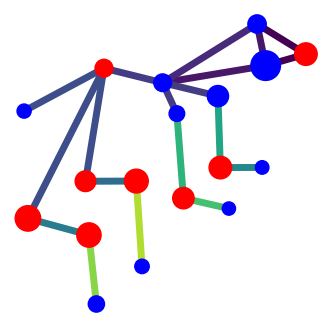

In [47]:
def center_embedding(n):
    """
    Generates a matrix ``Gamma`` that maps from a (n-1)-dimensional
    vector space  to the space of k-tuples with zero mean

    Parameters
    ----------
    n : int
        Number of keypoints.

    Returns
    -------
    Gamma: jax array of shape (n, n - 1)
        Matrix to map to centered embedded space.
    """
    X = np.tril(np.ones((n, n)), k=-1)[1:]
    X = np.eye(n)[1:] - X / X.sum(1)[:, None]
    X = X / np.sqrt((X**2).sum(1))[:, None]
    return X.T
Gamma = np.array(center_embedding(len(state_name)))

ymean = Gamma @ pca.mean_.reshape(len(state_name)-1, -1)
ymean[state_name.index('HeadB'), 2] -= 10
ymean[state_name.index('HeadF'), 0] += 10
ymean[state_name.index('SpineL'), 2] += 20
ymean[state_name.index('ShoulderL'), 0] += 20
ymean[state_name.index('ElbowL'), 0] += 20
ymean[state_name.index('ElbowL'), 2] += 10
ymean[state_name.index('ArmL'), 0] += 30
ymean[state_name.index('ArmL'), 2] += 10
ymean[state_name.index('ArmR'), 0] += 10
ymean[state_name.index('HipL'), 2] += 10
ymean[state_name.index('HipL'), 0] += 30
ymean[state_name.index('KneeL'), 2] += 10
ymean[state_name.index('KneeL'), 0] += 30
ymean[state_name.index('ShinL'), 2] += 10
ymean[state_name.index('ShinL'), 0] += 30
ymean[state_name.index('HipR'), 0] -= 10
ymean[state_name.index('HipR'), 2] += 10
fig, axes = plt.subplots(1, 1, figsize=(4, 4))
dims = [0, 2]
dims, name = [0,2], 'xz'
cmap = plt.cm.get_cmap('viridis')
keypoint_colors = cmap(np.linspace(0, 1, len(state_name)))
# print(keypoint_colors)
n_bodyparts = len(state_name)
ig_matrix_agg_xyz = np.load('./figure/rat7m/spedersac/dim64_sa_sp_buffer_20body_normalzied_lasso1e-2_xyz_group/0/ig_matrix_agg.npy')
for e in edges:
    axes.plot(
        *ymean[:, dims][e,:].T,
        color=keypoint_colors[e[0]],
        linewidth=5.0,
        zorder=0)
node_colors = ['blue' if ig_matrix_agg_xyz[0, j] < 0 else 'red' for j in range(2*n_bodyparts)]
axes.scatter(
        *ymean[:, dims].T,
        c=node_colors[:n_bodyparts],
        s=np.abs(ig_matrix_agg_xyz[0, :n_bodyparts])*120,
        zorder=1)
axes.axis('off')
plt.show()

In [48]:
np.save('ymean.npy', ymean)